## Project Setup

In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import pendulum
import seaborn as sns
from pathlib import Path
from datetime import datetime

In [2]:
pd.plotting.register_matplotlib_converters()

In [3]:
datasets_dir = str(Path(os.path.abspath('')).parent.joinpath("datasets"))

## OWID COVID-19 Dataset

### Dataset Cleanup

In [4]:
raw_covid_df = pd.read_csv(f"{datasets_dir}/owid-covid-data.csv")

In [5]:
raw_covid_df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
47956,NaN,NaN,International,2020-10-02,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47957,NaN,NaN,International,2020-10-03,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47958,NaN,NaN,International,2020-10-04,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
to_year_month = lambda date_str: pendulum\
                                    .parse(date_str)\
                                    .format("YYYY-MM")

In [7]:
staging_covid_df = raw_covid_df[raw_covid_df['continent'].notnull()].reset_index()

In [8]:
staging_covid_df['year_month'] = staging_covid_df.apply(lambda row: to_year_month(row['date']), axis=1)

### Splitting Countries according by  Cleanup

#### North and Central America

In [9]:
staging_covid_df.loc[ 
    (staging_covid_df['continent'] == 'North America') & 
    (~staging_covid_df['location'].isin(['United States', 'Canada', 'Mexico'])),
    'continent'
] = "Central America"

In [10]:
staging_covid_df.loc[staging_covid_df['continent'] == 'North America' ]['iso_code'].unique()

array(['CAN', 'MEX', 'USA'], dtype=object)

#### Eastern, Western, Northern, Southern Europe

In [11]:
#TODO

## Data Aggregation

### Data Aggregation by Country

In [12]:
covid_by_country = staging_covid_df\
                    .groupby(['location', 'iso_code', 'continent', 'year_month'], as_index=None)\
                    .agg({'new_cases': sum, 'new_deaths': sum})\
                    .sort_values(by=['year_month', 'location', 'continent'],
                                 ascending=[False, True, True])

covid_by_country.head(10)

,location,iso_code,continent,year_month,new_cases,new_deaths
10,Afghanistan,AFG,Asia,2020-10,43.0,4.0
18,Albania,ALB,Europe,2020-10,599.0,8.0
29,Algeria,DZA,Africa,2020-10,627.0,30.0
37,Andorra,AND,Europe,2020-10,144.0,0.0
45,Angola,AGO,Africa,2020-10,306.0,10.0
53,Anguilla,AIA,Central America,2020-10,0.0,0.0
61,Antigua and Barbuda,ATG,Central America,2020-10,6.0,0.0
70,Argentina,ARG,South America,2020-10,54209.0,4276.0
81,Armenia,ARM,Asia,2020-10,2024.0,14.0
89,Aruba,ABW,Central America,2020-10,140.0,4.0


### Data Aggregation by Continent

In [13]:
covid_by_continent = covid_by_country\
                        .groupby(['year_month', 'continent'], as_index=['year_month', 'continent'])\
                        .agg({'new_cases': sum, 'new_deaths': sum})

covid_by_continent

new_cases  new_deaths
year_month continent                             
2019-12    Africa                 0.0         0.0
           Asia                  27.0         0.0
           Central America        0.0         0.0
           Europe                 0.0         0.0
           North America          0.0         0.0
...                               ...         ...
2020-10    Central America    18333.0       352.0
           Europe            270332.0      2746.0
           North America     219183.0      5284.0
           Oceania              639.0        16.0
           South America     240660.0      9063.0

[77 rows x 2 columns]

### Data Aggregation by Period

In [14]:
covid_by_period = covid_by_country\
                    .groupby(['year_month'], as_index=['year_month'])\
                    .agg({'new_cases': sum, 'new_deaths': sum})

covid_by_period

,new_cases,new_deaths
year_month,,
2019-12,27.0,0.0
2020-01,9797.0,213.0
2020-02,74707.0,2702.0
2020-03,722387.0,35797.0
2020-04,2330512.0,189176.0
2020-05,2874101.0,140149.0
2020-06,4232988.0,134078.0
2020-07,7053151.0,166208.0
2020-08,7977431.0,178627.0


## Exploratory Data Analysis

In [15]:
continent_stats_by_period = covid_by_country.groupby(['year_month', 'continent']).describe()

In [16]:
world_stats_by_period = covid_by_period.groupby(['year_month']).describe()

### New Cases - Statistics per Period (Continental)

In [17]:
continent_case_stats_by_period = continent_stats_by_period\
                                    .new_cases\
                                    .join(covid_by_continent)\
                                    .rename(columns={'count': 'countries_reporting'})\
                                    .drop('new_deaths', axis=1)

continent_case_stats_by_period

countries_reporting          mean            std  \
year_month continent                                                           
2019-12    Africa                           3.0      0.000000       0.000000   
           Asia                            28.0      0.964286       5.102520   
           Central America                  1.0      0.000000            NaN   
           Europe                          27.0      0.000000       0.000000   
           North America                    3.0      0.000000       0.000000   
...                                         ...           ...            ...   
2020-10    Central America                 33.0    555.545455    1114.381417   
           Europe                          51.0   5300.627451   10713.951501   
           North America                    3.0  73061.000000  103085.888283   
           Oceania                          8.0     79.875000     123.654400   
           South America                   13.0  18512.307692   36576.563932   

                               min       25%      50%       75%       max  \
year_month continent                                                        
2019-12    Africa              0.0      0.00      0.0       0.0       0.0   
           Asia                0.0      0.00      0.0       0.0      27.0   
           Central America     0.0      0.00      0.0       0.0       0.0   
           Europe              0.0      0.00      0.0       0.0       0.0   
           North America       0.0      0.00      0.0       0.0       0.0   
...                            ...       ...      ...       ...       ...   
2020-10    Central America     0.0      0.00     18.0     377.0    4578.0   
           Europe              0.0    180.50    971.0    3986.5   55935.0   
           North America    7510.0  13650.00  19790.0  105836.5  191883.0   
           Oceania             0.0      2.25     12.0     107.5     298.0   
           South America       0.0    159.00   3351.0   13217.0  129311.0   

                            new_cases  
year_month continent                   
2019-12    Africa                 0.0  
           Asia                  27.0  
           Central America        0.0  
           Europe                 0.0  
           North America          0.0  
...                               ...  
2020-10    Central America    18333.0  
           Europe            270332.0  
           North America     219183.0  
           Oceania              639.0  
           South America     240660.0  

[77 rows x 9 columns]

### New Cases - Statistics per Period (WORLD)

In [18]:
world_case_stats_by_period = world_stats_by_period\
                                .new_cases\
                                .join(covid_by_period)\
                                .drop(['count', 'new_deaths'], axis=1)

world_case_stats_by_period

,mean,std,min,25%,50%,75%,max,new_cases
year_month,,,,,,,,
2019-12,27.0,NaN,27.0,27.0,27.0,27.0,27.0,27.0
2020-01,9797.0,NaN,9797.0,9797.0,9797.0,9797.0,9797.0,9797.0
2020-02,74707.0,NaN,74707.0,74707.0,74707.0,74707.0,74707.0,74707.0
2020-03,722387.0,NaN,722387.0,722387.0,722387.0,722387.0,722387.0,722387.0
2020-04,2330512.0,NaN,2330512.0,2330512.0,2330512.0,2330512.0,2330512.0,2330512.0
2020-05,2874101.0,NaN,2874101.0,2874101.0,2874101.0,2874101.0,2874101.0,2874101.0
2020-06,4232988.0,NaN,4232988.0,4232988.0,4232988.0,4232988.0,4232988.0,4232988.0
2020-07,7053151.0,NaN,7053151.0,7053151.0,7053151.0,7053151.0,7053151.0,7053151.0
2020-08,7977431.0,NaN,7977431.0,7977431.0,7977431.0,7977431.0,7977431.0,7977431.0


### New Victims - Statistics per Period (Continental)

In [19]:
continent_victim_stats_by_period = continent_stats_by_period\
                                    .new_deaths\
                                    .join(covid_by_continent)\
                                    .rename(columns={'count': 'countries_reporting'})\
                                    .drop('new_cases', axis=1)

continent_victim_stats_by_period

countries_reporting         mean          std  \
year_month continent                                                        
2019-12    Africa                           3.0     0.000000     0.000000   
           Asia                            28.0     0.000000     0.000000   
           Central America                  1.0     0.000000          NaN   
           Europe                          27.0     0.000000     0.000000   
           North America                    3.0     0.000000     0.000000   
...                                         ...          ...          ...   
2020-10    Central America                 33.0    10.666667    20.853157   
           Europe                          51.0    53.843137   121.797598   
           North America                    3.0  1761.333333  1612.957015   
           Oceania                          8.0     2.000000     3.891382   
           South America                   13.0   697.153846  1357.489033   

                              min    25%     50%      75%     max  new_deaths  
year_month continent                                                           
2019-12    Africa             0.0    0.0     0.0     0.00     0.0         0.0  
           Asia               0.0    0.0     0.0     0.00     0.0         0.0  
           Central America    0.0    0.0     0.0     0.00     0.0         0.0  
           Europe             0.0    0.0     0.0     0.00     0.0         0.0  
           North America      0.0    0.0     0.0     0.00     0.0         0.0  
...                           ...    ...     ...      ...     ...         ...  
2020-10    Central America    0.0    0.0     0.0     5.00    76.0       352.0  
           Europe             0.0    0.5     7.0    36.50   706.0      2746.0  
           North America    171.0  944.0  1717.0  2556.50  3396.0      5284.0  
           Oceania            0.0    0.0     0.0     1.75    11.0        16.0  
           South America      0.0    7.0   142.0   285.00  4276.0      9063.0  

[77 rows x 9 columns]

### New Victims - Statistics per Period (WORLD)

In [81]:
world_victim_stats_by_period = world_stats_by_period\
                                .new_deaths\
                                .join(covid_by_period)\
                                .drop(['count', 'new_cases', 'std'], axis=1)

world_victim_stats_by_period

,mean,min,25%,50%,75%,max,new_deaths
year_month,,,,,,,
2019-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01,213.0,213.0,213.0,213.0,213.0,213.0,213.0
2020-02,2702.0,2702.0,2702.0,2702.0,2702.0,2702.0,2702.0
2020-03,35797.0,35797.0,35797.0,35797.0,35797.0,35797.0,35797.0
2020-04,189176.0,189176.0,189176.0,189176.0,189176.0,189176.0,189176.0
2020-05,140149.0,140149.0,140149.0,140149.0,140149.0,140149.0,140149.0
2020-06,134078.0,134078.0,134078.0,134078.0,134078.0,134078.0,134078.0
2020-07,166208.0,166208.0,166208.0,166208.0,166208.0,166208.0,166208.0
2020-08,178627.0,178627.0,178627.0,178627.0,178627.0,178627.0,178627.0


### Aggregating Country, Continent and World Statistics

#### Merging Country New Cases with Continent and World Statistics

In [95]:
cases_df = covid_by_country.set_index(['year_month', 'continent'])\
    .merge(continent_case_stats_by_period, left_index=True, right_index=True)\
    .rename(columns={
        'new_cases_x': 'new_cases',
        'mean': 'cont_mean',
        'std': 'cont_std',
        'min': 'cont_min',
        'max': 'cont_max',
        '25%': 'cont_25%',
        '50%': 'cont_50%',
        '75%': 'cont_75%'
    })\
    .merge(world_case_stats_by_period, left_index=True, right_index=True)\
    .rename(columns={
        'new_cases_x': 'new_cases',
        'mean': 'world_mean',
        'std': 'world_std',
        'min': 'world_min',
        'max': 'world_max',
        '25%': 'world_25%',
        '50%': 'world_50%',
        '75%': 'world_75%'
    })\
    .drop(['new_deaths', 'new_cases_y', 'countries_reporting'], axis=1)\
    .reset_index()\
    .set_index(['year_month','location'])


In [96]:
cases_df

continent iso_code  new_cases     cont_mean  \
year_month location                                                       
2019-12    Algeria             Africa      DZA        0.0      0.000000   
           Egypt               Africa      EGY        0.0      0.000000   
           Nigeria             Africa      NGA        0.0      0.000000   
           Afghanistan           Asia      AFG        0.0      0.964286   
           Armenia               Asia      ARM        0.0      0.964286   
...                               ...      ...        ...           ...   
2020-10    Paraguay     South America      PRY     3351.0  18512.307692   
           Peru         South America      PER    13217.0  18512.307692   
           Suriname     South America      SUR       61.0  18512.307692   
           Uruguay      South America      URY       89.0  18512.307692   
           Venezuela    South America      VEN     2457.0  18512.307692   

                            cont_std  cont_min  cont_25%  cont_50%  cont_75%  \
year_month location                                                            
2019-12    Algeria          0.000000       0.0       0.0       0.0       0.0   
           Egypt            0.000000       0.0       0.0       0.0       0.0   
           Nigeria          0.000000       0.0       0.0       0.0       0.0   
           Afghanistan      5.102520       0.0       0.0       0.0       0.0   
           Armenia          5.102520       0.0       0.0       0.0       0.0   
...                              ...       ...       ...       ...       ...   
2020-10    Paraguay     36576.563932       0.0     159.0    3351.0   13217.0   
           Peru         36576.563932       0.0     159.0    3351.0   13217.0   
           Suriname     36576.563932       0.0     159.0    3351.0   13217.0   
           Uruguay      36576.563932       0.0     159.0    3351.0   13217.0   
           Venezuela    36576.563932       0.0     159.0    3351.0   13217.0   

                        cont_max  world_mean  world_std  world_min  world_25%  \
year_month location                                                             
2019-12    Algeria           0.0        27.0        NaN       27.0       27.0   
           Egypt             0.0        27.0        NaN       27.0       27.0   
           Nigeria           0.0        27.0        NaN       27.0       27.0   
           Afghanistan      27.0        27.0        NaN       27.0       27.0   
           Armenia          27.0        27.0        NaN       27.0       27.0   
...                          ...         ...        ...        ...        ...   
2020-10    Paraguay     129311.0   1255037.0        NaN  1255037.0  1255037.0   
           Peru         129311.0   1255037.0        NaN  1255037.0  1255037.0   
           Suriname     129311.0   1255037.0        NaN  1255037.0  1255037.0   
           Uruguay      129311.0   1255037.0        NaN  1255037.0  1255037.0   
           Venezuela    129311.0   1255037.0        NaN  1255037.0  1255037.0   

                        world_50%  world_75%  world_max  
year_month location                                      
2019-12    Algeria           27.0       27.0       27.0  
           Egypt             27.0       27.0       27.0  
           Nigeria           27.0       27.0       27.0  
           Afghanistan       27.0       27.0       27.0  
           Armenia           27.0       27.0       27.0  
...                           ...        ...        ...  
2020-10    Paraguay     1255037.0  1255037.0  1255037.0  
           Peru         1255037.0  1255037.0  1255037.0  
           Suriname     1255037.0  1255037.0  1255037.0  
           Uruguay      1255037.0  1255037.0  1255037.0  
           Venezuela    1255037.0  1255037.0  1255037.0  

[1874 rows x 17 columns]

#### Merging Country New Victims with Continent and World Statistics

In [94]:
victims_df = covid_by_country.set_index(['year_month', 'continent'])\
    .merge(continent_victim_stats_by_period, left_index=True, right_index=True)\
    .rename(columns={
        'new_deaths_x': 'new_victims',
        'mean': 'cont_mean',
        'std': 'cont_std',
        'min': 'cont_min',
        'max': 'cont_max',
        '25%': 'cont_25%',
        '50%': 'cont_50%',
        '75%': 'cont_75%'
    })\
    .merge(world_victim_stats_by_period, left_index=True, right_index=True)\
    .rename(columns={
        'mean': 'world_mean',
        'std': 'world_std',
        'min': 'world_min',
        'max': 'world_max',
        '25%': 'world_25%',
        '50%': 'world_50%',
        '75%': 'world_75%'
    })\
    .drop(['new_cases', 'new_deaths', 'new_deaths_y', 'countries_reporting'], axis=1)\
    .reset_index()\
    .set_index(['year_month','location'])


In [97]:
victims_df

continent iso_code  new_victims   cont_mean  \
year_month location                                                       
2019-12    Algeria             Africa      DZA          0.0    0.000000   
           Egypt               Africa      EGY          0.0    0.000000   
           Nigeria             Africa      NGA          0.0    0.000000   
           Afghanistan           Asia      AFG          0.0    0.000000   
           Armenia               Asia      ARM          0.0    0.000000   
...                               ...      ...          ...         ...   
2020-10    Paraguay     South America      PRY         72.0  697.153846   
           Peru         South America      PER        269.0  697.153846   
           Suriname     South America      SUR          2.0  697.153846   
           Uruguay      South America      URY          0.0  697.153846   
           Venezuela    South America      VEN         22.0  697.153846   

                           cont_std  cont_min  cont_25%  cont_50%  cont_75%  \
year_month location                                                           
2019-12    Algeria         0.000000       0.0       0.0       0.0       0.0   
           Egypt           0.000000       0.0       0.0       0.0       0.0   
           Nigeria         0.000000       0.0       0.0       0.0       0.0   
           Afghanistan     0.000000       0.0       0.0       0.0       0.0   
           Armenia         0.000000       0.0       0.0       0.0       0.0   
...                             ...       ...       ...       ...       ...   
2020-10    Paraguay     1357.489033       0.0       7.0     142.0     285.0   
           Peru         1357.489033       0.0       7.0     142.0     285.0   
           Suriname     1357.489033       0.0       7.0     142.0     285.0   
           Uruguay      1357.489033       0.0       7.0     142.0     285.0   
           Venezuela    1357.489033       0.0       7.0     142.0     285.0   

                        cont_max  world_mean  world_min  world_25%  world_50%  \
year_month location                                                             
2019-12    Algeria           0.0         0.0        0.0        0.0        0.0   
           Egypt             0.0         0.0        0.0        0.0        0.0   
           Nigeria           0.0         0.0        0.0        0.0        0.0   
           Afghanistan       0.0         0.0        0.0        0.0        0.0   
           Armenia           0.0         0.0        0.0        0.0        0.0   
...                          ...         ...        ...        ...        ...   
2020-10    Paraguay       4276.0     25109.0    25109.0    25109.0    25109.0   
           Peru           4276.0     25109.0    25109.0    25109.0    25109.0   
           Suriname       4276.0     25109.0    25109.0    25109.0    25109.0   
           Uruguay        4276.0     25109.0    25109.0    25109.0    25109.0   
           Venezuela      4276.0     25109.0    25109.0    25109.0    25109.0   

                        world_75%  world_max  
year_month location                           
2019-12    Algeria            0.0        0.0  
           Egypt              0.0        0.0  
           Nigeria            0.0        0.0  
           Afghanistan        0.0        0.0  
           Armenia            0.0        0.0  
...                           ...        ...  
2020-10    Paraguay       25109.0    25109.0  
           Peru           25109.0    25109.0  
           Suriname       25109.0    25109.0  
           Uruguay        25109.0    25109.0  
           Venezuela      25109.0    25109.0  

[1874 rows x 16 columns]

## Plotting

In [12]:
df = covid_df[(covid_df['location'] == 'Brazil') | 
              (covid_df['location'] == 'United States') |
              (covid_df['location'] == 'Germany') |
              (covid_df['location'] == 'France') |
              (covid_df['location'] == 'United Kingdom') |
              (covid_df['location'] == 'China')]

### Line Plotting

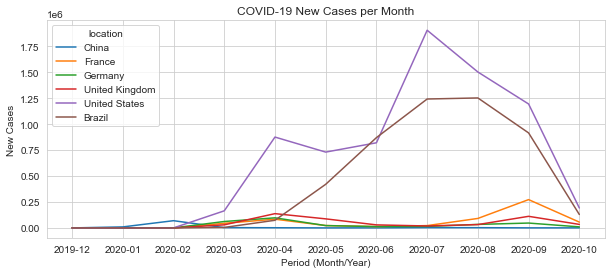

In [13]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 4))

sns.lineplot(x='year_month', 
             y='new_cases',    
             data=df,
             hue='location')
    
plt.xlabel("Period (Month/Year)")
plt.ylabel("New Cases")
plt.title(f"COVID-19 New Cases per Month")
plt.show()

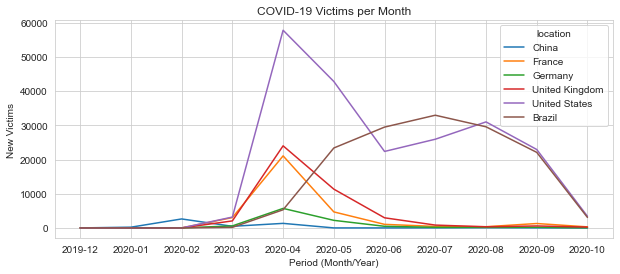

In [14]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 4))

sns.lineplot(x='year_month', 
             y='new_deaths',    
             data=df,
             hue='location')
    
plt.xlabel("Period (Month/Year)")
plt.ylabel("New Victims")
plt.title("COVID-19 Victims per Month")
plt.show()

### Bar Plotting - New Cases/Deaths

In [15]:
def bar_plot_cases_for(country: str):
    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 4))

    sns.barplot(x='year_month', 
                y=covid_df[covid_df['location']==country]['new_cases'],
                data=covid_df)
    
    plt.xlabel("Period (Month/Year)")
    plt.ylabel("New Cases")
    plt.title(f"COVID-19 New Cases per Month in {country}")
    plt.show()

In [16]:
def bar_plot_deaths_for(country: str):
    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 4))

    sns.barplot(x='year_month', 
                y=covid_df[covid_df['location']==country]['new_deaths'],
                data=covid_df)
    
    plt.xlabel("Period (Month/Year)")
    plt.ylabel("New Victims")
    plt.title(f"COVID-19 Victims per Month in {country}")
    plt.show()

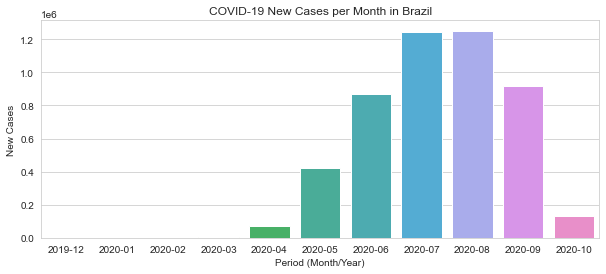

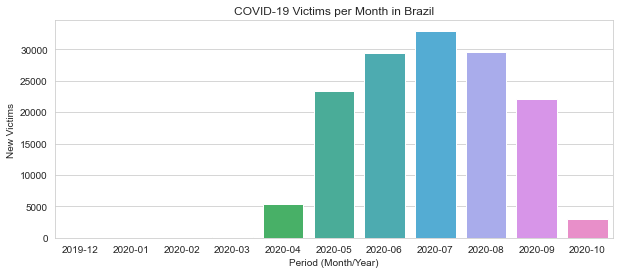

In [17]:
bar_plot_cases_for("Brazil")
bar_plot_deaths_for("Brazil")

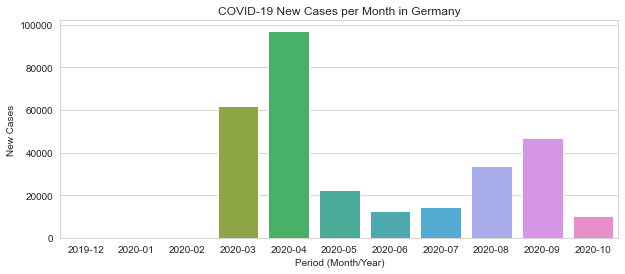

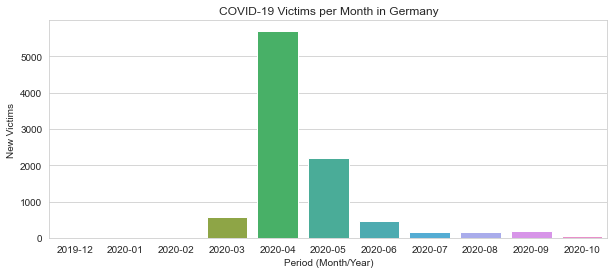

In [18]:
bar_plot_cases_for("Germany")
bar_plot_deaths_for("Germany")

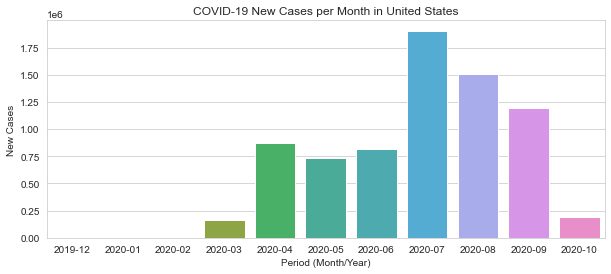

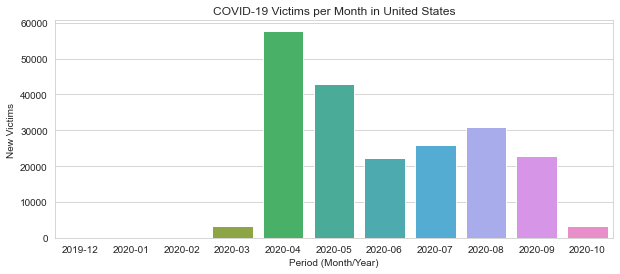

In [19]:
bar_plot_cases_for("United States")
bar_plot_deaths_for("United States")

### Scatter Plotting

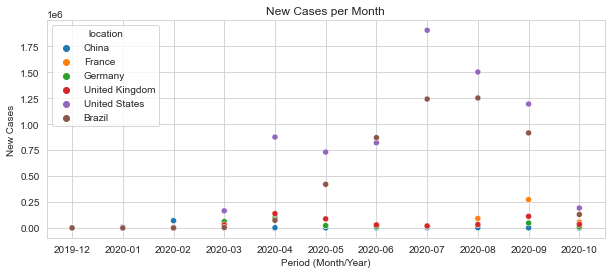

In [20]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 4))

sns.scatterplot(x='year_month', 
                y=df['new_cases'],
                hue=df['location'],
                data=df)

plt.xlabel("Period (Month/Year)")
plt.ylabel("New Cases")
plt.title(f"New Cases per Month")
plt.show()